# A Notebook for visual analysis of non precomputed embeddings. 

Examining intra and inter class variation of embeddings, make sure to choose embedding model and dataset wisely. \
Created by: Luke Meyers April 2024

Includes: 
* Create embeddings using pretrained model 
* visualize single IDs with black and white barcodes
* Display histograms of cosign distance for various mean treatments 
* visualize different subsets of dataset with UMAP
* save computed embeddings to dataframes

In [1]:
# ---- Necessary Imports
import yaml
import os
from glob import glob
import os
import pandas as pd
import json
from datetime import datetime
import pickle
import numpy as np
import sys

sys.path.insert(0,"/home/lmeyers/ReID_CNN/SCL_reID/")
#/home/lmeyers/ReID_CNN/model_comparison_vis.ipynb
from utils.pytorch_data import *
from models.pytorch_models import *




/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-26 16:23:46.665249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 16:23:47.592214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Create Embeddings Using Config file 

In [2]:
#dir containing training csvs to start working with 
test_file = '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch2/summer_bee_dataset_open_train_bee_64_ids_batch2_sample_num_64.csv'
train_file = '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch1/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64.csv'
#test on all of batch 2 (open set) gonna also test on all of batch 1 

results_file = './track_agglom_results_w_baselines.csv'

file_paths = []

In [2]:
"""A training and evaluation handle for multifeature agglomerator using precompueted embeddings"""
config_file = "/home/lmeyers/ReID_CNN/SCL_reID/yml_and_csv_files/reid_template.yml"

##### Open and read config 
try:
    with open(config_file) as f:
        config = yaml.safe_load(f)
    model_config = config['model_settings'] # settings for model building
    train_config = config['train_settings'] # settings for model training
    data_config = config['data_settings'] # settings for data loading
    eval_config = config['eval_settings'] # settings for evaluation
    torch_seed = config['torch_seed']
    verbose = config['verbose']
except Exception as e:
    print('ERROR - unable to open experiment config file. Terminating.')
    print('Exception msg:',e)

if verbose:
        now = datetime.now() # current date and time
        dt = now.strftime("%y-%m-%d %H:%M")
        print(f'Date and time when this experiment was started: {dt}')
        print("Data Settings:")
        print(data_config)
        print("Train Settings:")
        print(train_config)
        print("Model Settings:")
        print(model_config)

#SET GPU TO USE
os.environ["CUDA_VISIBLE_DEVICES"]=str(train_config['gpu'])
if verbose:
    print('Using GPU',train_config['gpu'])
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if verbose:
    print(f'Found device: {device}')

##### Set Random seeds 
torch.manual_seed(torch_seed)
np.random.seed(torch_seed)

##### Define some Miscl Utils
image_size = data_config['input_size']
images_per_track = 8 #data_config['images_per_track']
model_config['images_per_track'] = images_per_track
bs = data_config['batch_size']
#aggr_bs = data_config['aggregator_batch_size']



# ## Load dataloaders for feeding images through embedder 
# train_dataloader, valid_dataloader = get_train_valid_dataloaders(data_config)
# test_dataloader, ref_dataloader = get_test_ref_dataloaders(data_config,True)

# # Compute Embeddings
# train_embeddings, train_labels, train_tracks = get_embeddings_w_track(embedder,train_dataloader,device)
# print('Train embeddings made with',model_name,"shape:",train_embeddings.size())

# valid_embeddings, valid_labels, valid_tracks = get_embeddings_w_track(embedder,valid_dataloader,device)
# print('Valid embeddings made with',model_name,"shape:",valid_embeddings.size())

# test_embeddings, test_labels, test_tracks = get_embeddings_w_track(embedder,test_dataloader,device)
# print('Test embeddings made with',model_name,"shape:",test_embeddings.size())

# ref_embeddings, ref_labels, ref_tracks = get_embeddings_w_track(embedder,ref_dataloader,device)
# print('Reference embeddings made with',model_name,"shape:",ref_embeddings.size())

# print(ref_embeddings[0].size())


Date and time when this experiment was started: 24-11-26 16:23
Data Settings:
{'dataset': 'summer_2023', 'split_type': 'closed', 'fname_col': 'new_filepath', 'label_col': 'ID', 'cropped': False, 'crop_top': None, 'crop_left': None, 'crop_height': None, 'crop_width': None, 'input_size': [250, 250], 'batch_size': 64, 'percent_valid': 0.2, 'sample_valid': True, 'percent_reference': 0.1, 'sample_reference': True, 'aug_p': 0.3, 'datafiles': {'train': '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch2/summer_bee_dataset_open_train_bee_64_ids_batch2_sample_num_max.csv', 'valid': None, 'test': '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch1/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_max.csv', 'reference': None, 'query': None, 'gallery': None}, 'n_distractors': 9, 'image_id_col': 'image_id', 'gallery_id': 'gallery_id', 'iteration_id': 'iteration_id'}
Train Settings:
{'learning_rate': 0.001, 'num_epochs': 250, 'finetune_epochs': 150, 'margin': 0.2, 

In [3]:
import open_clip

bio_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')
bio_model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [3]:
insect_path = "/home/lmeyers/vit_base_patch16_pretrained.pth"

sys.path.insert(1,"/home/lmeyers/InsectFoundationModel/") 
from insect_models import *

state_dict = torch.load(insect_path,weights_only=True)["model_state_dict"]
print(state_dict.keys())

insect_model = vit_base_patch16()
insect_model.load_state_dict(state_dict,strict=False)
insect_model.to(device)

/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


odict_keys(['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'bloc

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): 

In [4]:
import torchvision
from transformers import ViTModel
from transformers import ViTFeatureExtractor, AutoImageProcessor
import sys



# print('Getting ViT feature extractor...')
model_name = 'google/vit-base-patch16-224-in21k'
model_path = "/home/lmeyers/contrastive_learning_new_training/64_ids_batch1_sample_num_64/checkpoints/50.pth"

feature_extractor = AutoImageProcessor.from_pretrained(model_name)

# model = torch.load(model_path)
vit_model = ViTModel.from_pretrained(model_name)
vit_model.to(device)

/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [6]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention_map(attention_layer, input_tensor):
    """
    Visualize the attention map of a given ViTAttention layer.

    Parameters:
    - attention_layer: The ViTAttention layer (with submodules for self-attention)
    - input_tensor: Input tensor to pass through the layer (shape: [batch_size, seq_len, feature_dim])

    Returns:
    - Displays an attention heatmap.
    """
    # Forward pass through the attention module to get the attention weights
    query = attention_layer.attention.query(input_tensor)
    key = attention_layer.attention.key(input_tensor)
    
    # Compute the dot product between query and key (scaled attention)
    attention_scores = torch.matmul(query, key.transpose(-1, -2)) / (input_tensor.size(-1) ** 0.5)
    
    # Optionally apply softmax to normalize attention scores
    attention_weights = torch.softmax(attention_scores, dim=-1)
    
    # Visualize the attention map for a single input (assumes batch size = 1)
    attention_map = attention_weights[0].detach().cpu().numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_map, cmap='viridis')
    plt.title('Attention Map')
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.show()

# Example usage:
# attention_layer = ViTAttention(...)  # The initialized ViTAttention layer
# input_tensor = torch.randn(1, seq_len, 768)  # Example input tensor
# visualize_attention_map(attention_layer, input_tensor)


In [7]:
print(bio_model)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [6]:
vis = bio_model.visual.transformer.resblocks
att_l = []
for block in vis:
    print(block.attention)
    

<bound method ResidualAttentionBlock.attention of ResidualAttentionBlock(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (ls_1): Identity()
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (c_fc): Linear(in_features=768, out_features=3072, bias=True)
    (gelu): GELU(approximate='none')
    (c_proj): Linear(in_features=3072, out_features=768, bias=True)
  )
  (ls_2): Identity()
)>
<bound method ResidualAttentionBlock.attention of ResidualAttentionBlock(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (ls_1): Identity()
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (c_fc): Linear(in_features=768, out_features=3072, bi

In [5]:
 
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_embeddings_bioclip(model, dataloader, loss_fn, miner, device, feature_extractor=None):
    embeddings = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                outputs = model(images)
                embeddings.append(outputs.detach().cpu().numpy())
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images]) #need to add pixel vals if clip , pooler_output if VIT 
                images = torch.tensor(images, dtype=torch.float).to(device)
                labels = batch['label'].to(device)
                outputs = model(images)[0][0]
            #hard_pairs = miner(outputs, labels)
            #loss += loss_fn(outputs, labels, hard_pairs).detach().cpu().numpy()
                embeddings.append(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    all_labels = np.array(all_labels)
    #loss/=k
    return embeddings, all_labels #loss
##########################################################################################

##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_embeddings_vit(model, dataloader, loss_fn, miner, device, feature_extractor=None):
    embeddings = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                outputs = model(images)
                embeddings.append(outputs.detach().cpu().numpy())
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images]) #need to add pixel vals if clip , pooler_output if VIT 
                images = torch.tensor(images, dtype=torch.float).to(device)
                labels = batch['label'].to(device)
                outputs = model(images)["pooler_output"]#[0][0]
            #hard_pairs = miner(outputs, labels)
            #loss += loss_fn(outputs, labels, hard_pairs).detach().cpu().numpy()
                embeddings.append(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    all_labels = np.array(all_labels)
    #loss/=k
    return embeddings, all_labels #loss
##########################################################################################
 
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_embeddings_insect_model(model, dataloader, loss_fn, miner, device, feature_extractor=None):
    embeddings = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                outputs = model(images)
                embeddings.append(outputs.detach().cpu().numpy())
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images]) #need to add pixel vals if clip , pooler_output if VIT 
                images = torch.tensor(images, dtype=torch.float).to(device)
                labels = batch['label'].to(device)
                outputs = model.forward_no_masking(images).squeeze()
            #hard_pairs = miner(outputs, labels)
            #loss += loss_fn(outputs, labels, hard_pairs).detach().cpu().numpy()
                embeddings.append(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    all_labels = np.array(all_labels)
    #loss/=k
    return embeddings, all_labels #loss
##########################################################################################


In [6]:
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity
miner = miners.TripletMarginMiner(margin=train_config['margin'], type_of_triplets="semihard", distance = CosineSimilarity())
miner_type = "semihard"
loss_fn = losses.TripletMarginLoss(train_config['margin'], distance = CosineSimilarity())

In [15]:


test_dataloader, reference_dataloader = get_dataset(data_config, 'test',generate_valid=True) #generate valid automatically

reference_embeddings, reference_labels= get_embeddings_vit(vit_model, reference_dataloader, loss_fn, miner, device, feature_extractor)
print('Got_reference_embeddings')
print(reference_embeddings.shape)
test_embeddings, test_labels = get_embeddings_vit(vit_model, test_dataloader, loss_fn, miner, device, feature_extractor)
print('Got test embeddings')
print(test_embeddings.shape)


# print(f'Reference (or Train) Loss: {reference_loss:.4f}')
# print(f'Test (or Query) Loss: {test_loss:.4f}')


Using 1026 samples for reference set
9238 total test samples


KeyboardInterrupt: 

In [7]:

test_dataloader, reference_dataloader = get_dataset(data_config, 'test',generate_valid=True) #generate valid automatically

reference_embeddings, reference_labels= get_embeddings_insect_model(insect_model, reference_dataloader, loss_fn, miner, device, feature_extractor)
print('Got_reference_embeddings')
print(reference_embeddings.shape)
test_embeddings, test_labels = get_embeddings_insect_model(insect_model, test_dataloader, loss_fn, miner, device, feature_extractor)
print('Got test embeddings')
print(test_embeddings.shape)


Using 1026 samples for reference set
9238 total test samples
Got_reference_embeddings
(1026, 196, 768)
Got test embeddings
(9238, 196, 768)


In [13]:
print(reference_labels.shape)
reference_embeddings = reference_embeddings.reshape((1026,150528))
print(reference_embeddings.shape)

(1026,)
(1026, 150528)


In [ ]:
test_embeddings = test_embeddings.reshape((9238,150528))
print(test_embeddings.shape)

Training kNN classifier with k=1
1NN test accuracy: 0.5638
Training kNN classifier with k=3
3NN test accuracy: 0.462

Per label 3NN test accuracy:
1	0.58
2	0.46
3	0.76
5	0.63
6	0.07
7	0.48
8	0.59
9	0.62
10	0.55
11	0.59
12	0.32
13	0.82
14	0.64
15	0.60
16	0.54
17	0.62
18	0.45
19	0.46
20	0.56
21	0.29
22	0.68
23	0.07
24	0.80
25	0.73
26	0.58
27	0.56
28	0.58
29	0.55
30	0.51
31	0.43
32	0.41
33	0.05
34	0.59
35	0.35
36	0.52
37	0.30
38	0.15
39	0.28
40	0.35
41	0.34
42	0.04
43	0.27
44	0.44
45	0.12
46	0.38
47	0.33
48	0.12
49	0.38
50	0.13
51	0.21
52	0.32
53	0.00
54	0.20
55	0.27
56	0.64
57	0.06
58	0.38
59	0.18
60	0.33
61	0.06
62	0.47
63	0.00
64	0.18

Printing Confusion Matrix:
[[134   7   7 ...   0   0   0]
 [  0  38   0 ...   0   0   0]
 [  0   1 132 ...   0   0   0]
 ...
 [  1   0   3 ...  36   0   0]
 [  0   0   1 ...   0   0   0]
 [  0   0   0 ...   0   0   6]]


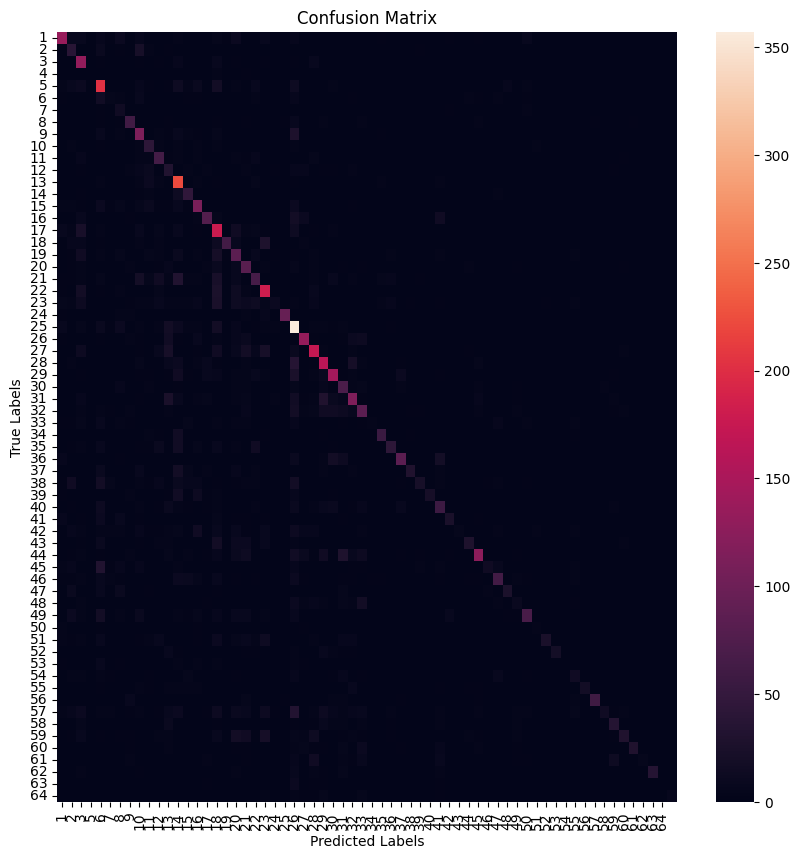

In [13]:
from train.pytorch_train_and_eval_reid_2 import knn_evaluation
eval = knn_evaluation(reference_embeddings,reference_labels,test_embeddings,test_labels,3)

from visualization.vis_utils import show_conf_matrix
show_conf_matrix(eval['knn_conf'],reference_labels,test_labels)



In [18]:
def convert_arr_2_df(data,labels):
    df = pd.DataFrame({"ID":labels})
    data = np.moveaxis(data,0,1)
    print(data.shape)
    for i in range(len(data)):
        df["feature_"+str(i)] = data[i]
    print(df.size)
    return df

df = convert_arr_2_df(test_embeddings,test_labels)

(512, 9238)
4739094


/tmp/ipykernel_7174/3535269160.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["feature_"+str(i)] = data[i]
/tmp/ipykernel_7174/3535269160.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["feature_"+str(i)] = data[i]
/tmp/ipykernel_7174/3535269160.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fram

In [25]:
df = df.sort_values("ID")

In [39]:
def showemb(df,cmap="Blues"):
  data = df.iloc[:,1:].values
  #data = np.linalg.norm(data,axis=0,keepdims=True)
  ilocs = []
  prev = -1
  ids = df['ID']
  for i in range(data.shape[0]):
    if ids.iloc[i]!=prev: 
      ilocs.append((i,ids.iloc[i]))
      print("new id at"+str(i))
    prev = ids.iloc[i]
  ilocs = np.array(ilocs)
  ids = ilocs[:,1]
  ilocs = ilocs[:,0]

  fig = plt.figure(figsize=(20,10))
  plt.imshow(data.T,cmap=cmap)
  gridpos = ilocs #np.arange(0,data.shape[0],3)
  #ids = df.loc[gridpos.astype(np.uint16),'ID'].values
  plt.xticks(gridpos-0.5, ids)
  #plt.yticks(fr-0.5, fr)
  plt.grid('x',color='r')
  plt.xlabel('samples for each ID')
  plt.ylabel('features')
  plt.axis('auto')
  plt.tight_layout()

new id at0
new id at229
new id at306
new id at481
new id at487
new id at802
new id at867
new id at906
new id at1012
new id at1195
new id at1271
new id at1381
new id at1483
new id at1754
new id at1825
new id at2013
new id at2156
new id at2449
new id at2575
new id at2764
new id at2909
new id at3128
new id at3393
new id at3537
new id at3656
new id at4131
new id at4362
new id at4672
new id at4952
new id at5223
new id at5371
new id at5633
new id at5848
new id at5921
new id at6016
new id at6143
new id at6311
new id at6418
new id at6560
new id at6630
new id at6794
new id at6867
new id at6992
new id at7100
new id at7384
new id at7507
new id at7677
new id at7757
new id at7839
new id at8015
new id at8040
new id at8149
new id at8213
new id at8243
new id at8308
new id at8372
new id at8467
new id at8671
new id at8759
new id at8936
new id at9024
new id at9103
new id at9177
new id at9205


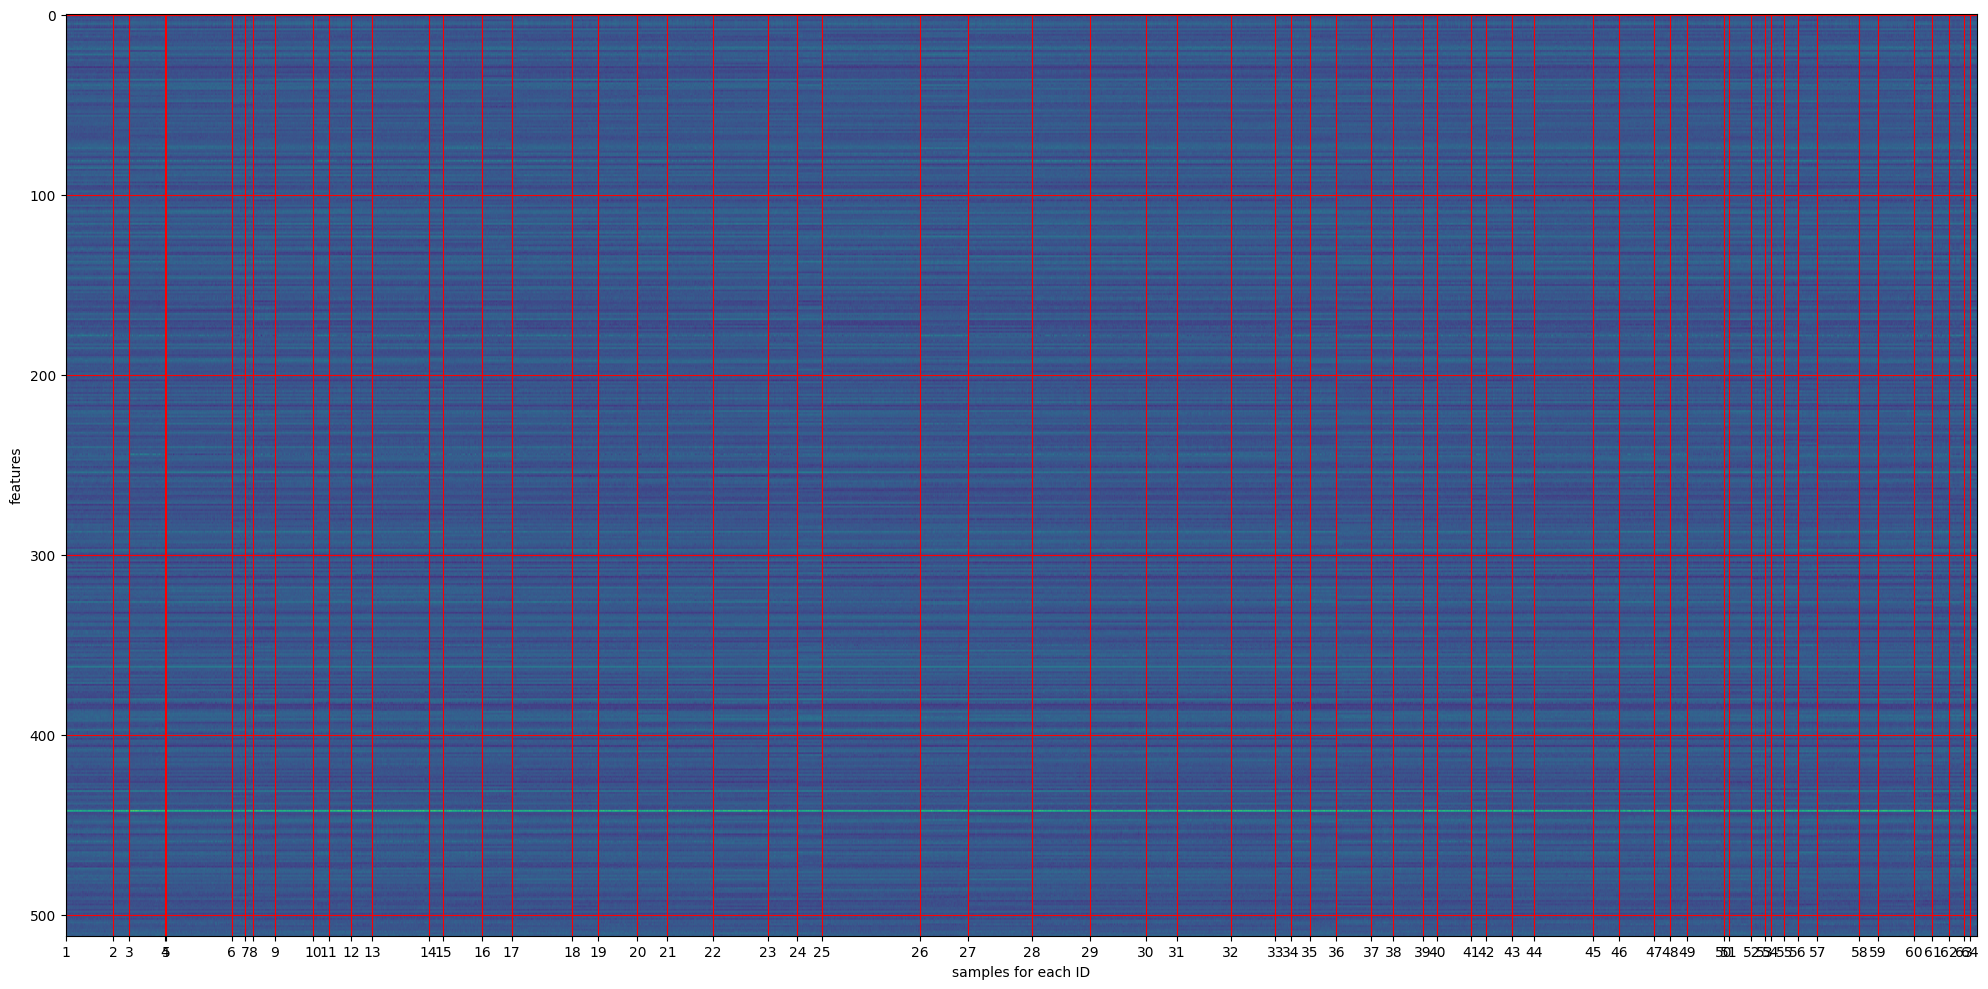

In [40]:
import matplotlib.pyplot as plt
showemb(df,"viridis")

In [4]:
index = 64
for i, batch in enumerate(valid_dataloader):
    if i == 0:
        img = batch['image'][index]
        label = batch['label'][index]
query_embedding = valid_embeddings[index].cpu().numpy()
#print(img.size())
#print(query_embedding)
#print(np.max(query_embedding))
print(label.item())


IndexError: index 64 is out of bounds for dimension 0 with size 32

In [5]:
print(np.unique(test_labels))

[ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128]


## Display all Barcodes for a Given ID

torch.Size([151, 128])
graphing embedding 0
In track 122
graphing embedding 1
In track 239
graphing embedding 2
In track 244
graphing embedding 3
In track 239
graphing embedding 4
In track 244
graphing embedding 5
In track 244
graphing embedding 6
In track 239
graphing embedding 7
In track 117
graphing embedding 8
In track 122
graphing embedding 9
In track 244
graphing embedding 10
In track 239
graphing embedding 11
In track 244
graphing embedding 12
In track 247
graphing embedding 13
In track 122
graphing embedding 14
In track 244
graphing embedding 15
In track 239
graphing embedding 16
In track 244
graphing embedding 17
In track 244
graphing embedding 18
In track 239
graphing embedding 19
In track 122
graphing embedding 20
In track 239
graphing embedding 21
In track 239
graphing embedding 22
In track 244
graphing embedding 23
In track 244
graphing embedding 24
In track 239
graphing embedding 25
In track 122
graphing embedding 26
In track 122
graphing embedding 27
In track 239
graphin

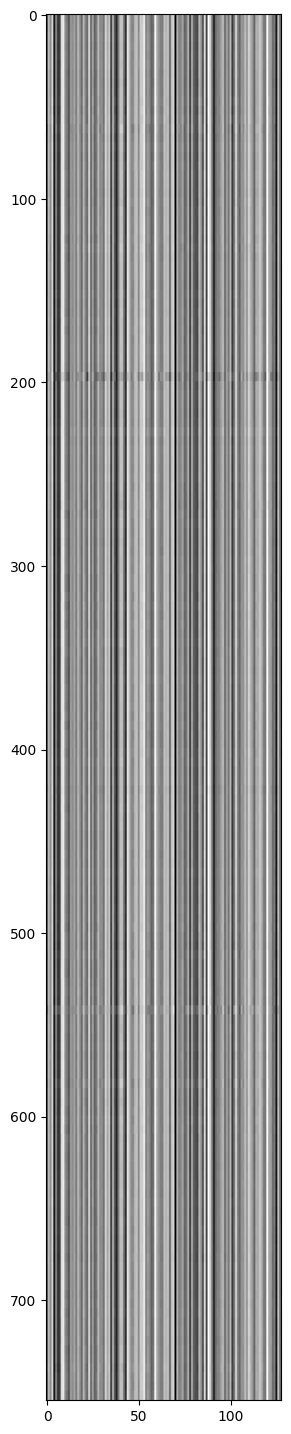

In [6]:
## display all barcodes in a given id 
index = 78
embs_id_27 = test_embeddings[test_labels == index]
tracks_id_27 = test_tracks[test_labels == index]
print(embs_id_27.size())

def display_barcode(vectors):
    """display all the vectors for a given id as a stack"""
    num = len(vectors)
    # Set the height of the barcode
    barcode_height = 5
    
    # Create figure for barcodes
    fig = plt.figure(figsize=(36,18)) #MAKE IT BIGG
    axs = plt.subplot()

    # Create an empty canvas for the barcode
    barcode = np.zeros((barcode_height*num, 1 * len(vectors[0])))

    for r in range(len(vectors)):
        vector = vectors[r]
        print("graphing embedding",r)
        #normalize vector
        normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
        #print(normalized_vector)
       
        # Fill the barcode with rectangles corresponding to the vector values
        for i, val in enumerate(normalized_vector):
            barcode[barcode_height*r: barcode_height*r + barcode_height, i:(i+2)] = val
        print("In track",tracks_id_27[r])
    # Display the barcode
    axs.imshow(barcode, cmap='gray')
    #axs.axis('off')

display_barcode(embs_id_27.cpu().numpy())


### Visualize all images for a given ID

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the ID you want to filter images for
target_id = index  # Replace 'index' with the desired ID

# Initialize an empty list to store images
images = []

# Iterate through the dataloader
for batch in valid_dataloader:
    # Get images and labels from the batch
    batch_images = batch['image']
    batch_labels = batch['label']
    batch_tracks = batch['track']
    
    # Iterate through the batch to filter images by the target ID
    for img, label in zip(batch_images, batch_labels):
        if label.item() == target_id:
            images.append(img.numpy())  # Convert image tensor to numpy array

# Concatenate the images into a grid layout
grid_size = int(np.ceil(np.sqrt(len(images))))
image_height, image_width, _ = images[0].shape  # Get image dimensions including channels
composite_image = np.zeros((grid_size * image_height, grid_size * image_width, 3))
for i, img in enumerate(images):
    row = (i % grid_size) * image_height
    col = (i % grid_size) * image_width
    img = np.moveaxis(img,0,-1) #make channels last 
    composite_image[row:row+image_height, col:col+image_width, :] = img

# Display the composite image
plt.figure(figsize=(12, 6))
plt.imshow(composite_image.astype(np.uint8))
plt.title(f'Composite Image for ID {target_id}')
plt.axis('off')
plt.show()


NameError: name 'index' is not defined

### Visualize a single image with its barcode

151
torch.Size([128])


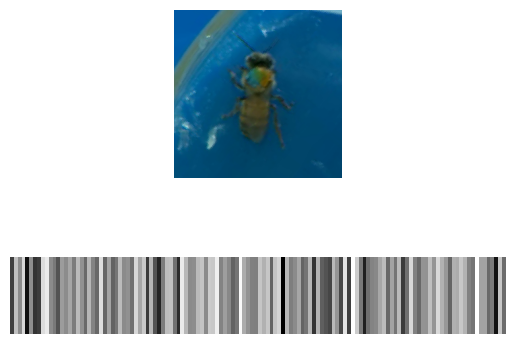

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize an empty list to store images
images = []
target_id = index

# Iterate through the dataloader
for batch in test_dataloader:
    # Get images and labels from the batch
    batch_images = batch['image']
    batch_labels = batch['label']
    batch_tracks = batch['track']
    
    # Iterate through the batch to filter images by the target ID
    for img, label in zip(batch_images, batch_labels):
        if label.item() == target_id:
            images.append(img)  # Convert image tensor to numpy array

print(len(images))
vector = test_embeddings[test_labels == target_id][3]

print(vector.size())

def display_image_and_barcode(pixel_values, vector):
    # Ensure pixel_values and vector are numpy arrays
    pixel_values = np.array(pixel_values)
    image = np.moveaxis(pixel_values,0,-1)
    vector = np.array(vector)
    

    # Check if the shape of pixel_values is correct
    if len(pixel_values.shape) != 3:
        raise ValueError("Input tensor shape must be (channels, height, width)")

    # #Transpose the tensor to the correct shape for displaying with matplotlib
    # image = np.transpose(pixel_values, (1, 2, 0))

    # Normalize vector values to range [0, 1]
    normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
   
    # Set the height of the barcode
    barcode_height = 20

    # Create an empty canvas for the barcode
    barcode = np.zeros((barcode_height, 1 * len(vector)))

    # Fill the barcode with rectangles corresponding to the vector values
    for i, val in enumerate(normalized_vector):
        barcode[:, i:(i+1)] = val

    # Create subplots for displaying image and barcode
    fig, axs = plt.subplots(2,1)

    # Display the image
    axs[0].imshow(image)
    axs[0].axis('off')

    # Display the barcode
    axs[1].imshow(barcode, cmap='gray')
    axs[1].axis('off')

    plt.show()


# Example usage:
# vector = ...  # Your 128-dimensional numpy array
# display_barcode(vector)
display_image_and_barcode(images[3],vector.cpu())

## Examine the intraclass means of the embeddings

torch.Size([1, 128])
torch.Size([128])


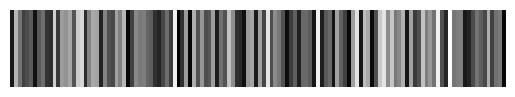

In [ ]:

from recognition_models import MeanAggregator

model = MeanAggregator(len(embs_id_27))

mean_vector = model(embs_id_27.unsqueeze(0))
print(mean_vector.size())
mean_vector = mean_vector.squeeze()

def display_ind_barcode(vector):
    # Normalize vector values to range [0, 1]
    normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
    print(normalized_vector.size())
    
    # Set the height of the barcode
    barcode_height = 20

    # Create an empty canvas for the barcode
    barcode = np.zeros((barcode_height, 1 * len(vector)))

    # Fill the barcode with rectangles corresponding to the vector values
    for i, val in enumerate(normalized_vector):
        barcode[:, i:(i+1)] = val

    # Create subplots for displaying image and barcode
    fig, axs = plt.subplots()

    # Display the barcode
    axs.imshow(barcode, cmap='gray')
    axs.axis('off')

    plt.show()




display_ind_barcode(mean_vector.cpu())

    

In [ ]:
### calculate mean cosine distances. 
##### calculate distance for each embedding to the mean of all in its id 

print(test_embeddings.size(),test_labels.shape)
#print(valid_labels[0:145])

dist_dict = {}
for id in np.unique(test_labels): 
    id_list = []
    print("embeddings in ID",id)
    comb = test_embeddings[test_labels==id]
    #print(comb.size())
    mean = torch.mean(comb,dim=0)
    for i in test_embeddings[test_labels==id]:
        target = i
        if mean.size() != target.size():
            print("error!")
            print(mean.size(),target.size())
        sim = torch.nn.functional.cosine_similarity(mean.unsqueeze(0),target.unsqueeze(0))
        id_list.append(sim.item())
    dist_dict[id] = id_list
print(dist_dict)
print(len(dist_dict[67]))

torch.Size([9483, 128]) (9483,)
embeddings in ID 65
embeddings in ID 66
embeddings in ID 67
embeddings in ID 68
embeddings in ID 69
embeddings in ID 70
embeddings in ID 71
embeddings in ID 72
embeddings in ID 73
embeddings in ID 74
embeddings in ID 75
embeddings in ID 76
embeddings in ID 77
embeddings in ID 78
embeddings in ID 79
embeddings in ID 80
embeddings in ID 81
embeddings in ID 82
embeddings in ID 83
embeddings in ID 84
embeddings in ID 85
embeddings in ID 86
embeddings in ID 87
embeddings in ID 88
embeddings in ID 89
embeddings in ID 90
embeddings in ID 91
embeddings in ID 92
embeddings in ID 93
embeddings in ID 94
embeddings in ID 95
embeddings in ID 96
embeddings in ID 97
embeddings in ID 98
embeddings in ID 99
embeddings in ID 100
embeddings in ID 101
embeddings in ID 102
embeddings in ID 103
embeddings in ID 104
embeddings in ID 105
embeddings in ID 106
embeddings in ID 107
embeddings in ID 108
embeddings in ID 109
embeddings in ID 110
embeddings in ID 111
embeddings in ID

In [22]:
#### calculate the distance between all embeddings and the means of all the other ids 

diff_dist_dict = {}
means = []
for id in np.unique(test_labels): 
    id_list = []
    print("embeddings in ID",id)
    comb = test_embeddings[test_labels==id]
    mean = torch.mean(comb,dim=0)
    means.append(mean) #may need.cpu.numpy for downstream task 

for id in np.unique(test_labels): 
    id_list = []
    print("embeddings in ID",id)
    for i in test_embeddings[test_labels==id]:
            target = i
            for mean in means:
                if mean.size() != target.size():
                    print("error!")
                    print(mean.size(),target.size())
                sim = torch.nn.functional.cosine_similarity(mean.unsqueeze(0),target.unsqueeze(0))
                id_list.append(sim.item())
    diff_dist_dict[id] = id_list
    
print(len(diff_dist_dict[65]))

embeddings in ID 65
embeddings in ID 66
embeddings in ID 67
embeddings in ID 68
embeddings in ID 69
embeddings in ID 70
embeddings in ID 71
embeddings in ID 72
embeddings in ID 73
embeddings in ID 74
embeddings in ID 75
embeddings in ID 76
embeddings in ID 77
embeddings in ID 78
embeddings in ID 79
embeddings in ID 80
embeddings in ID 81
embeddings in ID 82
embeddings in ID 83
embeddings in ID 84
embeddings in ID 85
embeddings in ID 86
embeddings in ID 87
embeddings in ID 88
embeddings in ID 89
embeddings in ID 90
embeddings in ID 91
embeddings in ID 92
embeddings in ID 93
embeddings in ID 94
embeddings in ID 95
embeddings in ID 96
embeddings in ID 97
embeddings in ID 98
embeddings in ID 99
embeddings in ID 100
embeddings in ID 101
embeddings in ID 102
embeddings in ID 103
embeddings in ID 104
embeddings in ID 105
embeddings in ID 106
embeddings in ID 107
embeddings in ID 108
embeddings in ID 109
embeddings in ID 110
embeddings in ID 111
embeddings in ID 112
embeddings in ID 113
embedd

In [19]:
#### calculate the distance between all embeddings and all the other embeddings in the same id ids 
in_id_dist_dict = {}
mean_dict = {}
for id in np.unique(test_labels): 
    id_list = []
    print("embeddings in ID",id)
    comb = test_embeddings[test_labels==id]
    mean = torch.mean(comb,dim=0)
    mean_list = []
    for i in comb:
            target = i
            for j in comb:
                if j.size() != target.size():
                    print("error!")
                    print(j.size(),target.size())
                sim = torch.nn.functional.cosine_similarity(j.unsqueeze(0),target.unsqueeze(0))
                id_list.append(sim.item())
            mean_sim = torch.nn.functional.cosine_similarity(mean.unsqueeze(0),target.unsqueeze(0))
            mean_list.append(mean_sim.item())
    in_id_dist_dict[id] = id_list
    mean_dict[id] = mean_list
    
print(len(in_id_dist_dict[65]))


embeddings in ID 65
embeddings in ID 66
embeddings in ID 67
embeddings in ID 68
embeddings in ID 69
embeddings in ID 70
embeddings in ID 71
embeddings in ID 72
embeddings in ID 73
embeddings in ID 74
embeddings in ID 75
embeddings in ID 76
embeddings in ID 77
embeddings in ID 78
embeddings in ID 79
embeddings in ID 80
embeddings in ID 81
embeddings in ID 82
embeddings in ID 83
embeddings in ID 84
embeddings in ID 85
embeddings in ID 86
embeddings in ID 87
embeddings in ID 88
embeddings in ID 89
embeddings in ID 90
embeddings in ID 91
embeddings in ID 92
embeddings in ID 93
embeddings in ID 94
embeddings in ID 95
embeddings in ID 96
embeddings in ID 97
embeddings in ID 98
embeddings in ID 99
embeddings in ID 100
embeddings in ID 101
embeddings in ID 102
embeddings in ID 103
embeddings in ID 104
embeddings in ID 105
embeddings in ID 106
embeddings in ID 107
embeddings in ID 108
embeddings in ID 109
embeddings in ID 110
embeddings in ID 111
embeddings in ID 112
embeddings in ID 113
embedd

## Display calculated distances in grid format

In [3]:

### ---------------------------modify here which case you want to show
dict_to_display = diff_dist_dict

# Define the number of rows and columns for subplots
num_rows = 8
num_cols = 8

# Calculate the total number of subplots needed
total_plots = len(dict_to_display)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

# Flatten axes to iterate over them easily
axes = axes.flatten()

# Iterate over IDs and their similarity values to create histograms
for i, (id, sim_values) in enumerate(dict_to_display.items()):
    ax = axes[i]
    ax.hist(sim_values, bins=10, alpha=0.7, color='blue')
    ax.set_title(f'ID {id}')
    ax.set_xlabel('Cos Similarity to Means of All IDs')
    ax.set_ylabel('Frequency')
    #ax.set_xlim(.99, 1)  # Set the same X axis range for all subplots
    
    # Calculate the average similarity value
    mean_sim_value = np.mean(mean_dict[id])
    
    # Add a red vertical line at the average similarity value
    ax.axvline(x=mean_sim_value, color='red', linestyle='--', label='Mean dist to Intraclass Mean')
    ax.legend()  # Show legend for the red vertical line

# Hide empty subplots
for i in range(total_plots, num_rows * num_cols):
    axes[i].axis('off')


plt.tight_layout()
plt.show()

NameError: name 'diff_dist_dict' is not defined

## Display subsets of data using UMAP

Combining  2  embeddings for id  1
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  2
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  3
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  4
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  5
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  6
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  7
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  8
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  9
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  10
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  11
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  12
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  13
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  14
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  15
torch.Size([2, 128])
(128,)
Combining  2  embeddings for id  16
torch.Size([2

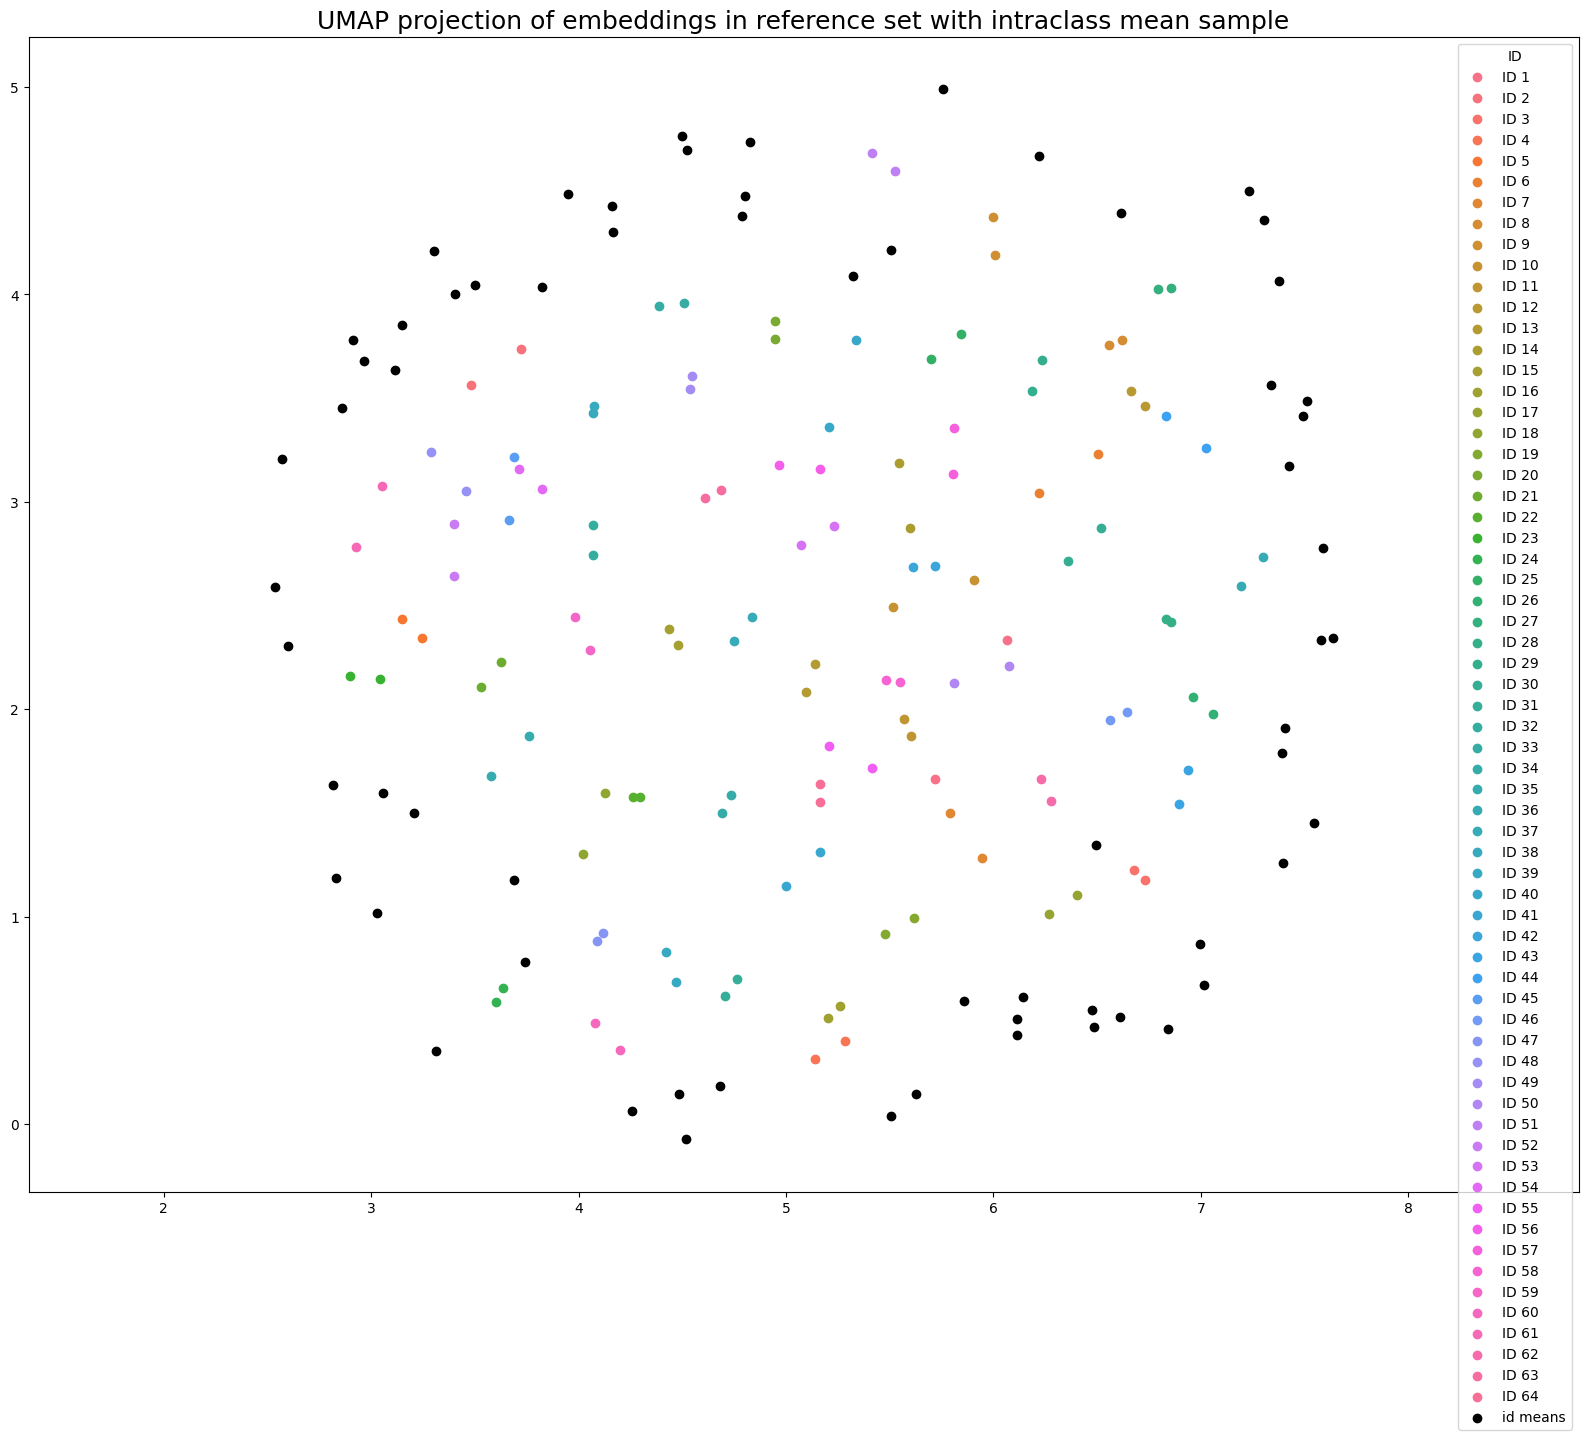

In [3]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from recognition_models import MeanAggregator

model = MeanAggregator(2)

# mean_vector = model(embs_id_27.unsqueeze(0))
# print(mean_vector.size())
# mean_vector = mean_vector.squeeze()


means = []
means_ids = []
for id in np.unique(ref_labels): 
    comb = ref_embeddings[ref_labels==id]
    print("Combining ",len(comb)," embeddings for id ",id)
    print(comb.size())
    mean = model(comb.unsqueeze(0))
    mean = mean.squeeze()
    print(mean.cpu().numpy().shape)
    #mean = torch.mean(comb,dim=0)
    means.append(mean.cpu().numpy()) #may need.cpu.numpy for downstream task 
    means_ids.append(id)

    

# Create Umap object
reducer = umap.UMAP()
embs = ref_embeddings.cpu().numpy()
reducer.fit(embs)
embedding = reducer.transform(embs)

#print(np.unique(embedding))

means_umap = reducer.transform(means)

# Get unique IDs
unique_ids = np.unique(ref_labels)

# Generate a color palette without repeating colors
n_colors = len(unique_ids)
color_palette = sns.color_palette('husl', n_colors=n_colors)

# Map IDs to colors
id_to_color = {id: color_palette[i] for i, id in enumerate(unique_ids)}

# Plot the UMAP projection
plt.figure(figsize=(20,15))
for id in unique_ids:
    mask = (ref_labels == id)
    plt.scatter(
        embedding[mask,0],
        embedding[mask,1],
        c = [id_to_color[id]],
        label=f'ID {id}'
        )

plt.scatter(
    means_umap[:, 0],
    means_umap[:, 1],
    c='black',  # or any color you prefer
    label='id means'
)


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of embeddings in reference set with intraclass mean sample', fontsize=18)
plt.legend(title='ID')
plt.show()


Combining  160  embeddings for id  65
Combining  81  embeddings for id  66
Combining  234  embeddings for id  67
Combining  225  embeddings for id  68
Combining  338  embeddings for id  69
Combining  155  embeddings for id  70
Combining  197  embeddings for id  71
Combining  243  embeddings for id  72
Combining  344  embeddings for id  73
Combining  42  embeddings for id  74
Combining  177  embeddings for id  75
Combining  104  embeddings for id  76
Combining  173  embeddings for id  77
Combining  151  embeddings for id  78
Combining  65  embeddings for id  79
Combining  270  embeddings for id  80
Combining  269  embeddings for id  81
Combining  364  embeddings for id  82
Combining  207  embeddings for id  83
Combining  111  embeddings for id  84
Combining  274  embeddings for id  85
Combining  157  embeddings for id  86
Combining  193  embeddings for id  87
Combining  114  embeddings for id  88
Combining  28  embeddings for id  89
Combining  290  embeddings for id  90
Combining  279  

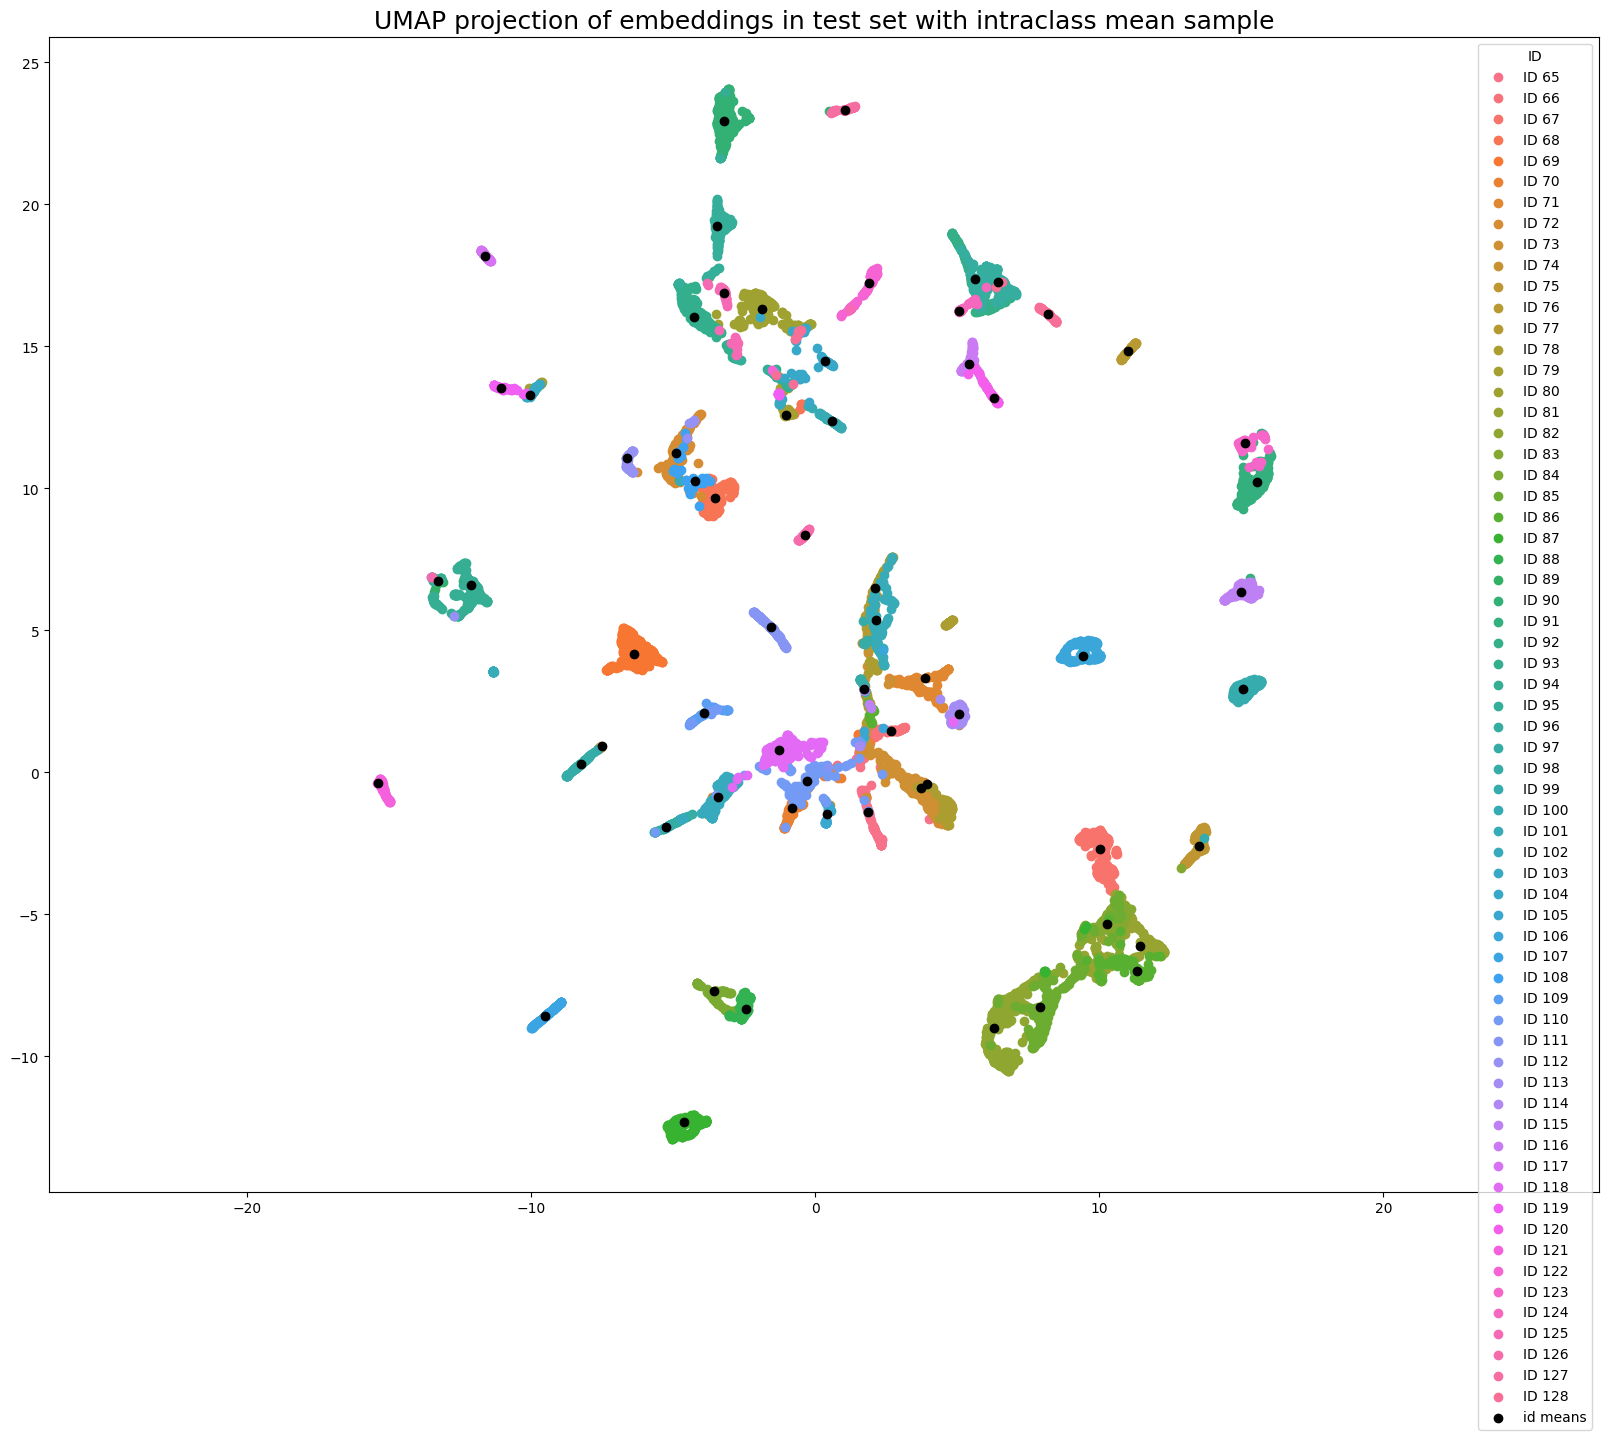

In [5]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from recognition_models import MeanAggregator


# mean_vector = model(embs_id_27.unsqueeze(0))
# print(mean_vector.size())
# mean_vector = mean_vector.squeeze()


means = []
for id in np.unique(test_labels): 
    id_list = []
    comb = test_embeddings[test_labels==id]
    print("Combining ",len(comb)," embeddings for id ",id)
    model = MeanAggregator(len(comb))
    mean = model(comb.unsqueeze(0))
    mean = mean.squeeze()
    #mean = torch.mean(comb,dim=0)
    means.append(mean.cpu().numpy()) #may need.cpu.numpy for downstream task 

# Create Umap object
reducer = umap.UMAP()
embs = test_embeddings.cpu().numpy()
reducer.fit(embs)
embedding = reducer.transform(embs)

print(np.unique(embedding))

means = reducer.transform(means)

# Get unique IDs
unique_ids = np.unique(test_labels)

# Generate a color palette without repeating colors
n_colors = len(unique_ids)
color_palette = sns.color_palette('husl', n_colors=n_colors)

# Map IDs to colors
id_to_color = {id: color_palette[i] for i, id in enumerate(unique_ids)}

# Plot the UMAP projection
plt.figure(figsize=(20,15))
for id in unique_ids:
    mask = (test_labels == id)
    plt.scatter(
        embedding[mask,0],
        embedding[mask,1],
        c = [id_to_color[id]],
        label=f'ID {id}'
        )

plt.scatter(
    means[:, 0],
    means[:, 1],
    c='black',  # or any color you prefer
    label='id means'
)


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of embeddings in test set with intraclass mean sample', fontsize=18)
plt.legend(title='ID')
plt.show()


## Save Computed Embeddings to Dataframe

In [6]:
ref_embeddings_np = ref_embeddings.cpu().numpy()
print(ref_embeddings_np.shape)
#means_np = np.array(means)
#means_ids = np.array(means_ids)
#print(means_np.shape)
print(ref_labels.shape)
#print(means_ids.shape)



data = {'ID':ref_labels,'Track':ref_tracks,'Type':"sample"}
df = pd.DataFrame(data)
#df = pd.concat((df,pd.DataFrame({"ID":means_ids,"Type":"mean"})),ignore_index=True)

#all_embs = np.concatenate((ref_embeddings_np,means_np))
all_embs = ref_embeddings_np
embs_cols = {}
for i in range(all_embs.shape[1]):  # Iterate over the second dimension of the array (128 in this case)
    column_name = f'Feature_{i}'  # Name for the new column
    embs_cols[column_name] = pd.Series(all_embs[:, i])  # Create a new column with values from the corresponding position in the array

df = pd.concat([df,pd.DataFrame(embs_cols)],axis=1)


print(len(df))
df.tail()

df.to_csv('./ref_embeddings_batch_2_images_batch_1_model_n=8.csv')


(504, 128)
(504,)
504
